# Separating Mouse and Human Antibody Sequences using Protein Encoding and Machine Learning Classifiers

### Questions:

- How may we create a machine learning classifier that can tell apart two groups of proteins?

- How may we improve upon the performance of a machine learning classifier that does not perform so well?

- How may we check for overfitting in a trained machine learning classifier?

- How may we pick the most relevant data points that are related to the class of a sample?

- Can we also train a deep learning predictor to tell proteins apart?

### Objectives:
    
- Understand how protein sequences can become readable to machine learning predictors

- Practise machine learning optimisation techniques including GridSearchCV and dimensionality reduction

- Check for overfitted data by testing with a totally naive dataset

- Pracitse prediction by applying a deep learning model to the problem and evaluating its performance


### Introduction 

If we want to generate a classifier that observes the differences between two groups of protein seequences, then we need to extract numerical information from our sequences. This is called encoding and can be done through a variety of ways inlcuding residue level encoding of each amino acid in your sequences with a 1x20 vector, representing the possibility of 20 amino acids at each residue. This is called One Hot Encoding, but often leads to a sparse dataset which is not suitable for machine learning tasks, and each sequence must be spaced out so they are of equal length. Instead, in this example we use the physiochemical properties that may be calculated from the sequence as our numeric information (ElAbd *et al.*, 2020). 

Antibodies are made up of two heavy and two light chains, however, the functional antigen-binding domains are Fv fragments at each fork of the "Y" shape. These Fv fragments are where the VH domain of a heavy chain and VL domain of a light chain interact and so much study has been dedicated to these regions. An antibody record is considered "paired" when both the VH and VL sequences of one antibody are known. This knowledge was rare in the past and came from studying individual antibodies, however, the advent of B-cell encapsulation and Next Generation Sequencing now allowed researchers to sequence a repertoire of paired antibodies (Rajan *et al.*, 2018).

In this exercise, we will use a sample of 1000 Human and 1000 Mouse paired antibodies taken from the Observed Antibody Space (Olsen *et al.*, 2022) and develop a machine learning classifier to separate them. Firstly, we will use Propythia (Sequeira *et al.*, 2022) to generate our encodings from an input of Fasta formatted sequences. Secondly, we will split those encodings into training and test datasets for a selection of machine learning classifiers and plot our results. Finally we will try to improve our performance through principal component analysis (PCA), which also helps to visualise our dataset.

### References

ElAbd, H., Bromberg, Y., Hoarfrost, A., Lenz, T., Franke, A., & Wendorff, M. (2020). Amino acid encoding for deep learning applications. BMC Bioinformatics, 21(1), 235. https://doi.org/10.1186/s12859-020-03546-x

Olsen, T. H., Boyles, F., & Deane, C. M. (2022). Observed Antibody Space: A diverse database of cleaned, annotated, and translated unpaired
and paired antibody sequences. Protein Science, 31(1), 141–146. https://doi.org/https://doi.org/10.1002/pro.4205

Sequeira, A. M., Lousa, D., & Rocha, M. (2022). ProPythia: A Python package for protein classification based on machine and deep learning.
Neurocomputing, 484, 172–182. https://doi.org/https://doi.org/10.1016/j.neucom.2021.07.102

Rajan, S., Kierny, M. R., Mercer, A., Wu, J., Tovchigrechko, A., Wu, H., Dall′Acqua, W. F., Xiao, X., & Chowdhury, P. S. (2018). Recombinant
human B cell repertoires enable screening for rare, specific, and natively paired antibodies. Communications Biology, 1(1), 5. https://doi.org/10.1038/s42003-017-0006-2


## Imports and Requirements
The antibody encoding method we will be using is the Propythia program. Before starting we recommend installing it by copying and pasting the following command in your terminal/command line:

`pip install propythia`

The machine learning models that we will use are imported from the sklearn package. We also suggest installing this via the following command: 

`pip install sklearn`

As this is a large package, rather than importing the whole package, it is better practise to just import the fuctions we require. As this usually leaves with a lot of import statements, we have broken them down what imports are required at what stage of the process.

In [2]:
##Get Encodings###
import sys
import pandas as pd
from pandas import read_csv
sys.path.append('../src/')
sys.path.append('')
from propythia.sequence import ReadSequence
sequence=ReadSequence()
from propythia.descriptors import Descriptor


##Data preparation###
from sklearn.utils import check_random_state, shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy import pi, linspace, cos, sin, append, ones, zeros, hstack, vstack, intp
from numpy import mgrid, linspace, c_, arange, mean, array
from numpy.random import uniform, seed


##Machine Learning Models###
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation


##Plotting Results###
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits import mplot3d
from matplotlib.pyplot import subplots, axes, scatter, xticks
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef


##Model Optimisation###
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


## Generating the Encoded Dataset

Here we input our fasta file and split the entries into VH and VL sequences. We put each set of sequecnes through the Propythia encoder a dataframe of numerical information for both VH and VL sequences. There are 4000 records in the fasta file representing 2000 paired antibodies: 1000 human and 1000 mouse.

In [3]:
###Propythia Command to get encodings###
def get_descriptors(protein):
    ##This will retrieve a selection of encodings that are not dependent on the sequence length##
    test= protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21])
    return(test)

In [31]:
def Get_dataset(fasta):
    VH_sequences = []
    VL_sequences = []
    with open(fasta, "r") as f:
        for line in f:
            if line[0] == ">":
                if "_VH" in line:
                    sequence_to_add = f.readline().strip()
                    VH_sequences.append(sequence_to_add)
                elif "_VL" in line:
                    sequence_to_add = f.readline().strip()
                    VL_sequences.append(sequence_to_add)

    print(len(VH_sequences),len(VL_sequences))
    if len(VH_sequences) == len(VL_sequences):
        VH_dataframe = pd.DataFrame()
        VL_dataframe = pd.DataFrame()
        for i in range(len(VH_sequences)):
            ps_string=sequence.read_protein_sequence(VH_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            #VH_dataframe.loc[len(VH_dataframe)] = descriptors
            VH_dataframe = VH_dataframe._append(descriptors, ignore_index=True)
        print("VH_data", VH_dataframe.shape)
        for i in range(len(VL_sequences)):
            ps_string=sequence.read_protein_sequence(VL_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            #VL_dataframe.loc[len(VL_dataframe)] = descriptors
            VL_dataframe = VL_dataframe._append(descriptors, ignore_index=True)
        print("VL_data", VL_dataframe.shape)
    # Now we join these two dataframes together so that each sample now has information about its VH and VL sequence.
    VH_dataframe_suffix = VH_dataframe.add_suffix('_VH')
    VL_dataframe_suffix = VL_dataframe.add_suffix('_VL')
    joined_dataframe_VH_VL =  VH_dataframe_suffix.join(VL_dataframe_suffix)
    return(joined_dataframe_VH_VL)


In [5]:
### Input Fasta and Run Dataset###
input_fasta = './HumanMouseOAS_VH_VL_paired_data.faa'

#joined_dataframe_VH_VL = Get_dataset(input_fasta)

#Optionally save dataframe as a CSV to simply reload it in future
#joined_dataframe_VH_VL.to_csv('./HumanMouseOAS_VH_VL_paired_data.faa_Full_descriptors')#
joined_dataframe_VH_VL = read_csv('./HumanMouseOAS_VH_VL_paired_data.faa_Full_descriptors.csv', header = 0)

### Do it yourself
- These encodings used with Propythia were selected to reduce the time taken to run. Retry the encoding step and experiment with the protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]) array.

- NB Propythia accepts numbers 0-40 however we avoid 1, 2 and 37 as these produce outputs of differing length

Now we have our encodings, we need to prepare our labels. As our input was ordered 1000 Human antibodies and 1000 Mouse antibodies we can simply make a list showing only these:

In [6]:
RANDOM_SEED = 0
#Prepare training data and labels
labels1 = 1000*[1] ##Human antibodies will be class 1
labels2 = 1000*[0] ## Mouse antibodies will be class 0
labels = labels1+labels2
y=labels
print(len(y))
##Mouse ==1, Human == 0

dataset = joined_dataframe_VH_VL
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']
print(dataset.shape) ##Just to check that you have an equal number of labels to the number of samples


2000
(2000, 890)


Now that we have our datasets, we may not split them into training datasets for fitting our classifiers to and training datasets to verify their effectiveness as predictors. Usually 70/30 or 80/20 split is necessary.

In [7]:

X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)


Training set size:  (1400, 890)        Test set size:  (600, 890)


## Separating our data with Machine Learning Classifiers
Here is our list of classifiers that we will loop through to see which is the best at clustering our dataset:

In [8]:
n=2
RANDOM_SEED=42



#    'KNeighbours': KNeighborsClassifier(2),
 #   'Guassian':GaussianMixture(n_components=n),
 #   'KMeans': KMeans(n_clusters=n) ,

classifiers = {
    'SVC':SVC(kernel="linear", C=0.025),
    'SVC2': SVC(gamma=2, C=1),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'MLPC': MLPClassifier(alpha=1, max_iter=1000),
    'ADABoost':AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QDA':QuadraticDiscriminantAnalysis(),
}


Now loop over our classifiers and use the test and train datasets to generate a score to validate the classifiers. I have chosen Matthews Correlation Coefficient (MCC) which is a metric less prone to bias by taking into account false predictions, as well as true predictions. This metric lies on a score between -1 (inverse prediction) and 1 (perfect prediction) with 0 being coin toss likelihood. We then plot our results as a confusion matrix which demonstrates the predictive power of our classifiers. The Confusion matrix shows the raw number of records that have been assigned to each category in a 2x2 matrix and is given as such: 

|                  | Predicted Class = 0  | Predicted Class = 1 |
|------------------|----------------------|---------------------|
| Actual Class = 0 | True Negative        | False Positive      |
| Actual Class = 1 |  False Negative      | True Positive       |

Ideally we want the True Negative and True Positive field to be the most popular fields with only a few records in the false positive fields.

N.B.: Results may vary between each run due to the stochastic nature of the machine learning algorithms.

### Do it yourself
- This is not an exhaustive list of classifiers. These were mostly picked to represent all of the different kinds of models. 
Here you will find a much larger list of classifiers. Try adding some to the classifiers dictionary and see how the results differ.
Additional models that are supported in scikit learn can be found here: https://scikit-learn.org/stable/supervised_learning.html

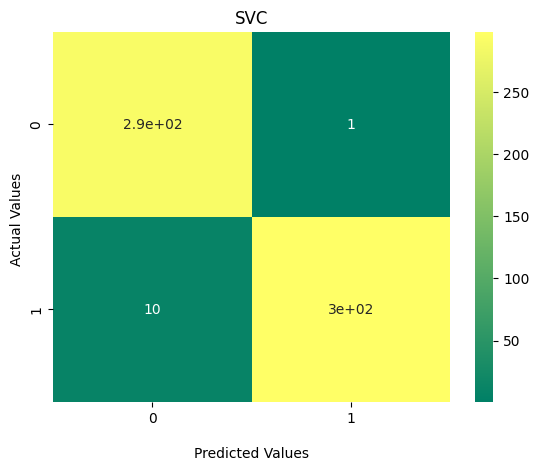

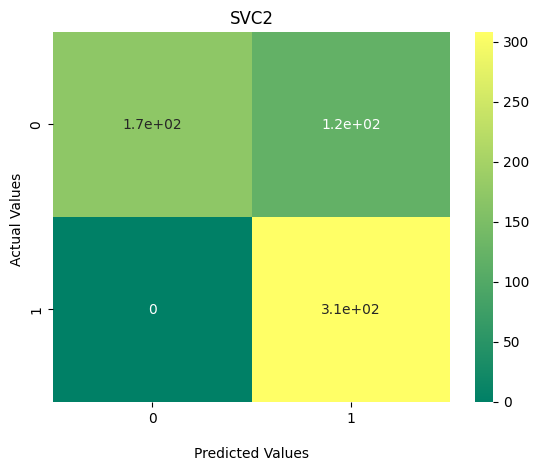

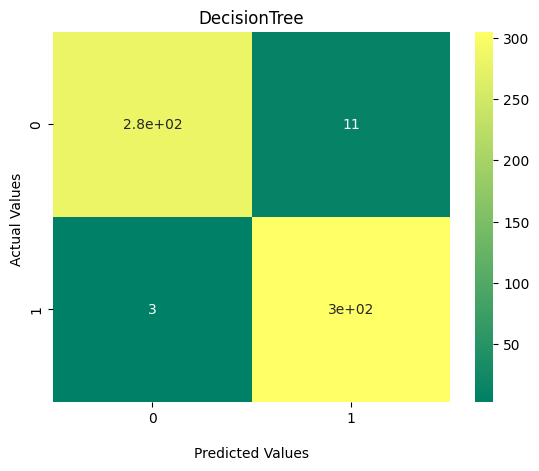

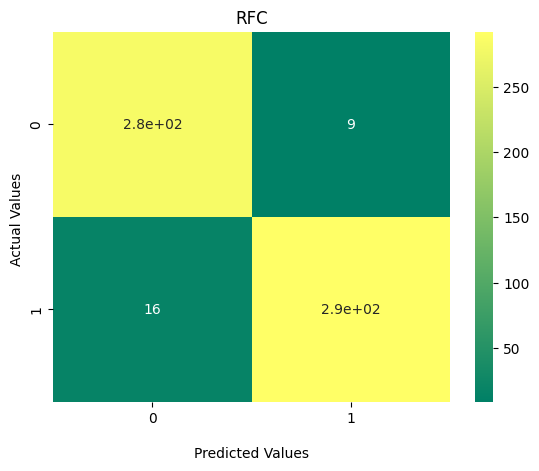

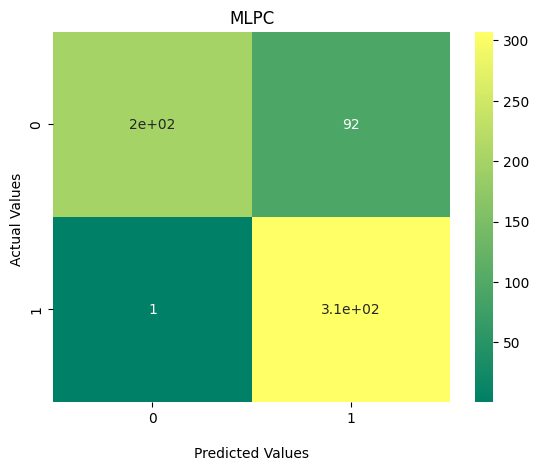

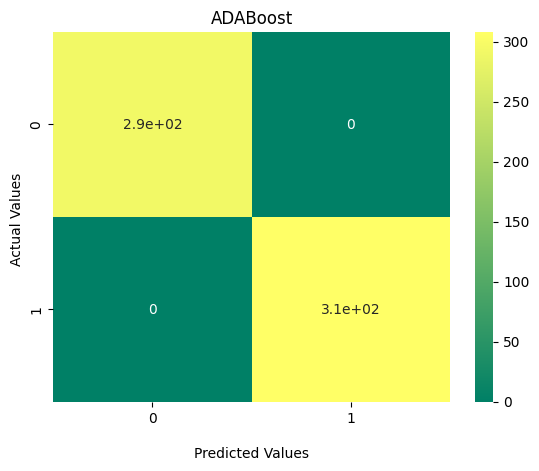

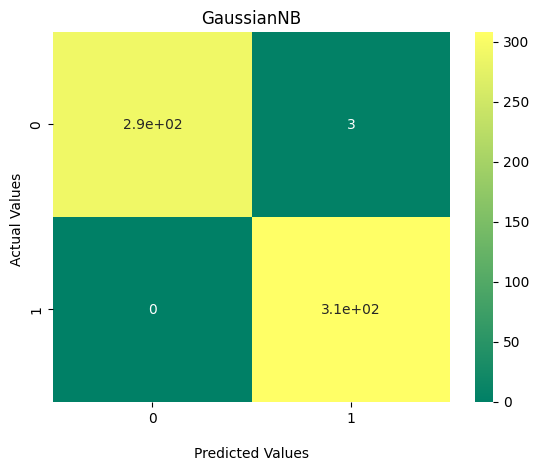

/Users/james/anaconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


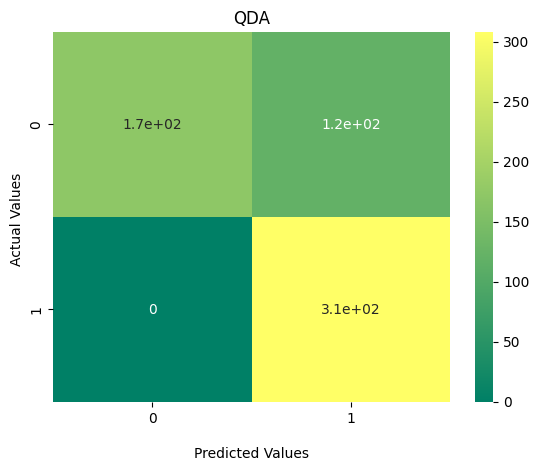

In [46]:
##Loop through each classifier, fit training data and evaluate model. Plot results as confusion matrix##
scores = []

for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_train,y_train)
    y_predict1 = clf_1.predict(X_test)
    scoring = matthews_corrcoef(y_test, y_predict1)
    scores.append(scoring) 
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict1)
    ax1 = sns.heatmap(confusion_matrix, annot=True, cmap='summer')
    title = str(i)
    ax1.set_title(title);
    ax1.set_xlabel('\nPredicted Values')
    ax1.set_ylabel('Actual Values ');
    plt.show()



Next, we can plot our MCC scores by classifier to see which performed best.

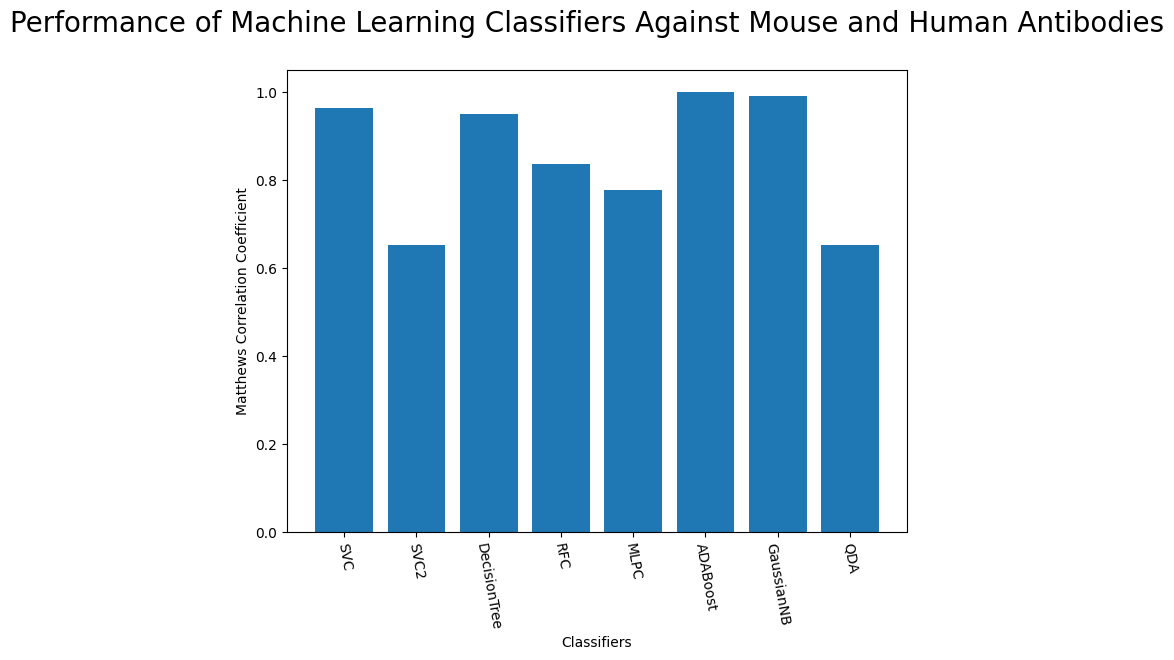

In [19]:
##Plot Performance of all Models##
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies', fontsize=20)

bins = arange(len(classifiers))
ax.bar(arange(len(scores)), scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=-80);

From the above chart, we can see that the best performing predictors are ADA_Boost, GaussinNB, DecisionTree and SVC are the best performing classifier, wheras both Gaussian and KMeans are the worst performing with negative MCC scores.


## Improving the Performance of Machine Learning Predictors

When a machine learning predictor is performing well, there is always the possibility of improving its performance through hyperparameterisation. This means editing its parameters until a maximum score and optimisation are reached. This is usually done through either GridSearchCV, which does this using a reference grid and systematically compares each combination with every other; or RandomSearchCV - which is more stochastic and, instead, samples from ranges which may be applied to each parameter. Here we will apply the GridSearchCV on both the SVC2 and RandomForestClassifier predictor, in order to try and increase its performance on our dataset.

It is important to know that not all classifiers have the capacity for GridSearchCV.

N.B. These processes will likely take a few minutes.

In [12]:
##GridsearchCV of SVC Model####
param_grid = {'C':[1],
              'gamma':[1,0.001],
}

svc = SVC()
svc_grid_search = GridSearchCV(estimator = svc, param_grid=  param_grid,
                               refit = True, n_jobs = -1,verbose = 2)
svc_grid_search.fit(X_train,y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10], 'gamma': [1, 0.001]}, verbose=2)

In [13]:
##GridsearchCV of RFC Model####

param_grid = {
    'min_samples_split': [8, 12],
    'n_estimators': [100, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          refit = True, cv = 3, n_jobs = -1, verbose = 2)
rf_grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_split': [8, 12],
                         'n_estimators': [100, 1000]},
             verbose=2)

Let's plot some additional confusion matrices to check if these classifiers are working better after GridsearchCV

{'C': 10, 'gamma': 0.001}


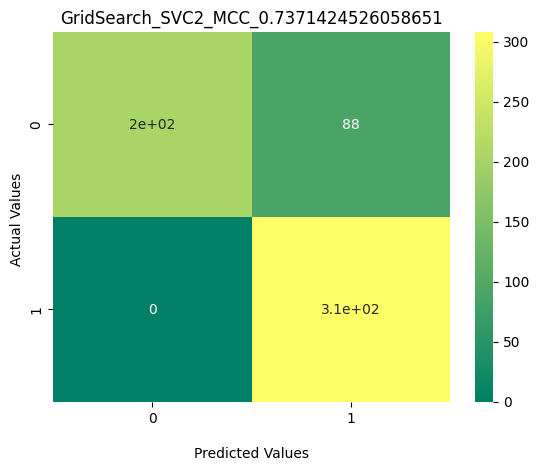

In [21]:
##Plot SVC GRID SEARCH CONFUSION MATRIX###
print(svc_grid_search.best_params_) ##Print the parameters which achieved the best score
y_predict1 = svc_grid_search.predict(X_test)
svc_grid_search_scoring = matthews_corrcoef(y_test, y_predict1)
cf_matrix1 = metrics.confusion_matrix(y_test, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("GridSearch_SVC2_MCC_"+str(svc_grid_search_scoring))
ax1.set_title(title);
ax1.set_xlabel('\nPredicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()

{'min_samples_split': 8, 'n_estimators': 1000}


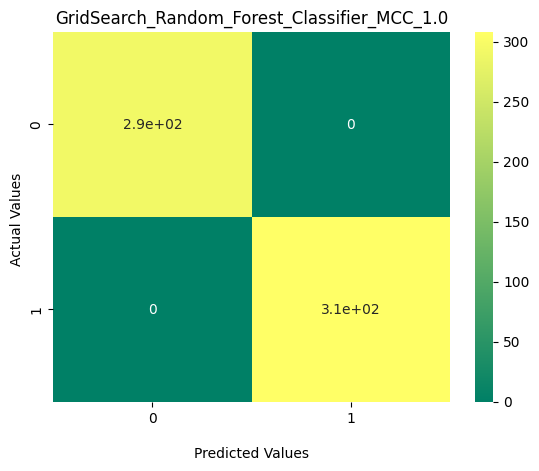

In [22]:
##Plot RFC GRID SEARCH CONFUSION MATRIX###

print(rf_grid_search.best_params_) ##Print the parameters which achieved the best score
y_predict1 = rf_grid_search.predict(X_test)
rf_grid_search_scoring = matthews_corrcoef(y_test, y_predict1)
cf_matrix1 = metrics.confusion_matrix(y_test, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("GridSearch_Random_Forest_Classifier_MCC_"+str(rf_grid_search_scoring))
ax1.set_title(title);
ax1.set_xlabel('\nPredicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()

We can also compare the old MCC score to the new one and see how they have improved for ourselves.

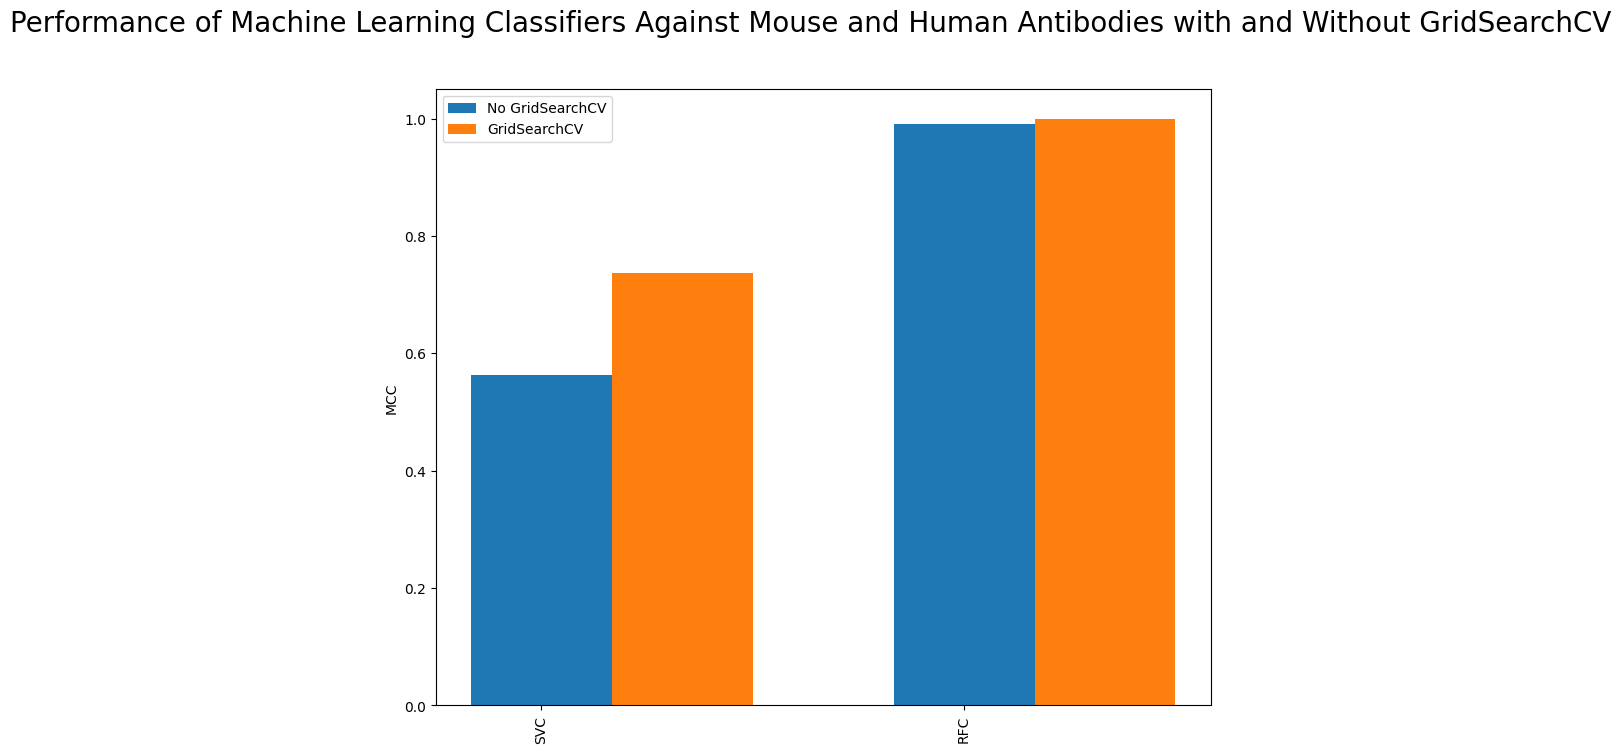

In [23]:
##Plot MCC values of SVC and RFC Models with and without GridsearchCV##
import numpy as np 
import matplotlib.pyplot as plt

classifiers2 = ["SVC","RFC"]
no_grid_scores = [scores[4],scores[6]]
grid_scores = [svc_grid_search_scoring, rf_grid_search_scoring] 
labels = classifiers2
aranged = np.arange(len(classifiers2)) 
width = 1/3

fig, ax = plt.subplots(figsize=(10,8))

bar1 = plt.bar(aranged, no_grid_scores, width,label = 'No GridSearchCV')
bar2 = plt.bar(aranged+width, grid_scores , width,label = 'GridSearchCV')
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies with and Without GridSearchCV', fontsize=20)
ax.set_ylabel('MCC')
ax.set_xticks(aranged, labels, rotation = 90)
ax.legend()


plt.legend()
plt.show()

We can see that both classifiers have an improved performance, however we have not seen substantial performance in the Support Vector Machine, so perhaps additional parameters need to be investigated.

## Do it yourself

- GridSearchCV is not the only kind of hyperparameter optimisation technique. RandomizedSearchCV is similar to GridSearchCV but instead of iterating over every combination of specified parameter, it randomly samples intervals for for a given number of iterations and notes which settings score the best. Documentation can be found here: https://scikit-learn.org/stable/supervised_learning.html

- Try optimising the Random Forest Classifier with RandomizedSearchCV instead and see how similar the best parameters are and how similar the MCC values are.

## Feature Importance

A Random Forest Classifier has a feature importance instance, where the features that contribute most highly to the determination of the classifier may be examined and plotted as percentages of their contribution. Using the best hyperparameters found by the GridSearchCV alogrithm, we may declare a new Random Forest and investigate which features are the most significant.


/var/folders/r7/969c1s5942x9xn1z91z7rvgw0000gn/T/ipykernel_13504/1769456946.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_feature_names[:49], rotation=-90);


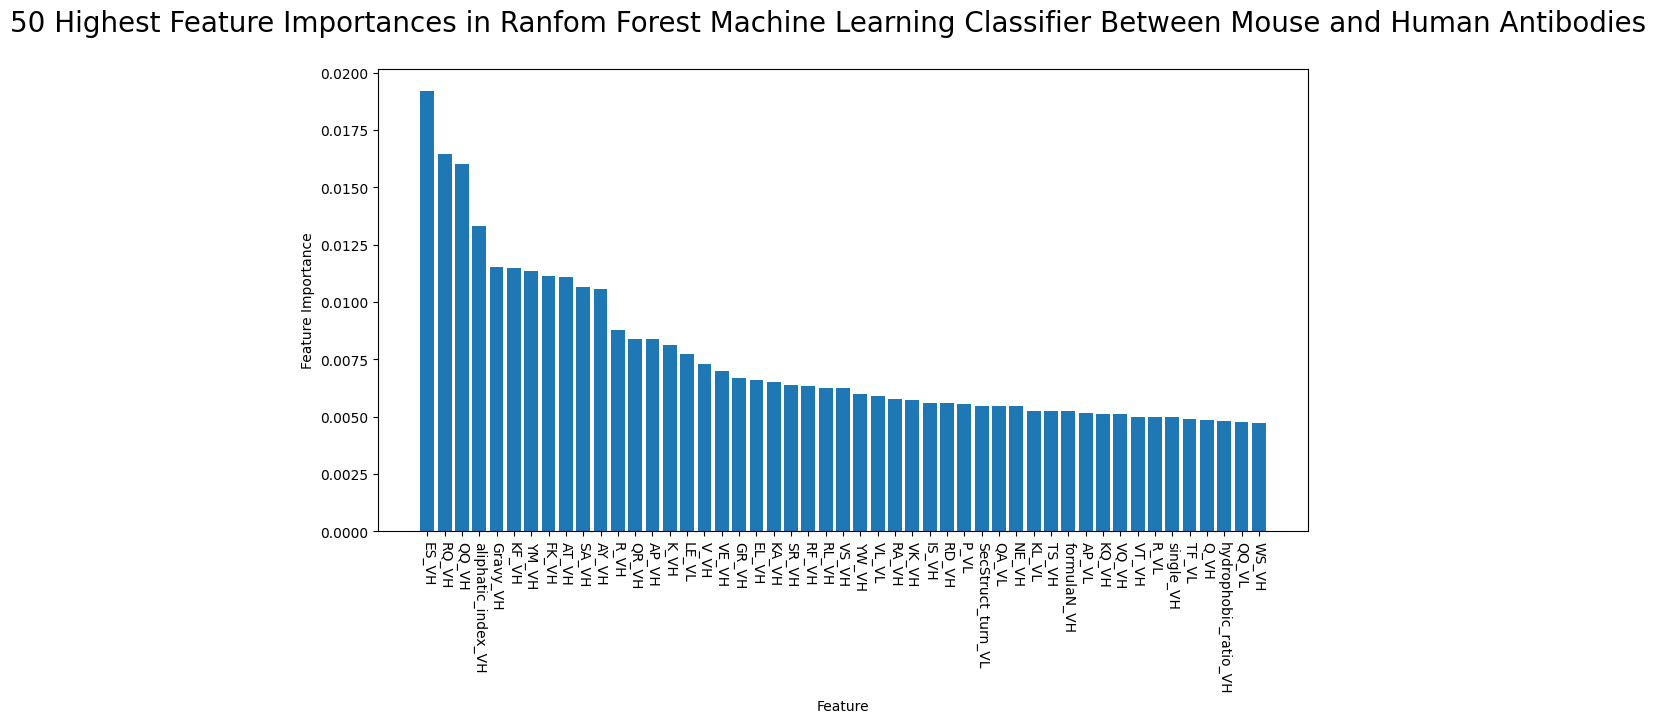

In [24]:
##Get Feature Importance from RFC Model and Plot Top 50 Features###
RF_Best_Params = RandomForestClassifier(bootstrap= True, max_depth=80, max_features=3, min_samples_leaf= 3, min_samples_split= 10, n_estimators= 100)
RF_Best_Params.fit(X_train, y_train)
importances  =  RF_Best_Params.feature_importances_
sorted_importances = sorted(importances, reverse=True)
feature_names = X_train.columns
sorted_feature_names = [feature_names for _, feature_names in sorted(zip(importances, feature_names), reverse = True)]
fig, ax = plt.subplots(figsize=(12,6))

plt.suptitle('50 Highest Feature Importances in Ranfom Forest Machine Learning Classifier Between Mouse and Human Antibodies', fontsize=20)
ax.bar(sorted_feature_names[:49], sorted_importances[:49])
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_xticklabels(sorted_feature_names[:49], rotation=-90);
plt.show()

It seems most of the important features are related to amino acid composition, which is not surprising as this would be where the superficial diffierences in mouse and human sequences lay.

## Do it yourself
We now have a list of all the feature names sorted by feature importance. By using the code below we can rework our dataframe to the 50 most important features:

`X = X[sorted_feature_names][:49]`

- Try running the classifiers again, but this time use the top 50 features only as your input data. See how that improves each classifier. Are all of them improved?

## Testing our Classifiers on a Naïve Dataset

We can also take a totally naïve dataset that the model has not been exposed to. This is a measure that checks for overfitting. If we see that there is poor performance on this naïve "held back" dataset, then it could suggest overfitting to the training data. Using 20 Human and 20 mouse paired sequences from OAS, which were not used to train our models, it is possible to generate their encodings, and pass them through the optimised model, in order to test it.  In this case, we will use only the top-performing models: ADABoost and GuassianNB.

In [32]:
##Get Encodings for the Naïve Dataset###
naive_fasta = './Naive_dataset.faa.txt'
naive_dataset = Get_dataset(naive_fasta)
naive_labels1 = 20*[1]
naive_labels2 = 20*[0]
naive_labels = naive_labels1+naive_labels2
naive_y=naive_labels

40 40
VH_data (40, 445)
VL_data (40, 445)


We should select high performing classifiers to test this naive dataset. We select the ADABoost and our improved RFC predictors to try this.

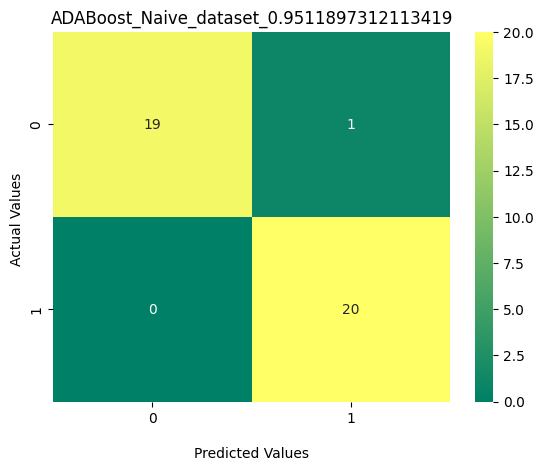

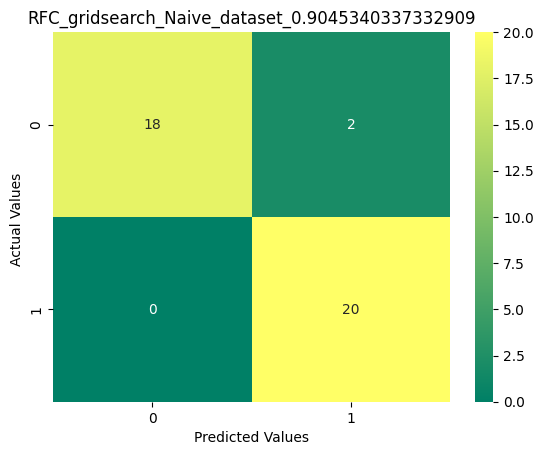

In [36]:
###Predict the Classes of Naïve Datasets Using or Previously Fitted ADABoost and GRIDSEARCHCV RFC Models and Plot Confusion Matrix##
clf = classifiers.get('ADABoost')
y_predict1 = clf.predict(naive_dataset)
scoring = matthews_corrcoef(naive_y, y_predict1)
scores.append(scoring)     
cf_matrix1 = metrics.confusion_matrix(naive_y, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("ADABoost_Naive_dataset_"+str(scoring))
ax1.set_title(title);
ax1.set_xlabel('\nPredicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()


naive_labels = naive_labels1+naive_labels2
naive_y=naive_labels
clf = rf_grid_search
y_predict1 = clf.predict(naive_dataset)
scoring = matthews_corrcoef(naive_y, y_predict1)
scores.append(scoring)     
cf_matrix1 = metrics.confusion_matrix(naive_y, y_predict1)
ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
title = str("RFC_gridsearch_Naive_dataset_"+str(scoring))
ax1.set_title(title);
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values ');
plt.show()


It seems even GridSearchCV has not improved the RFC to the extent of the ADABoost, but it still shows good overall performance! As expected, we don't see very good performance with KMeans as it has mostly thought that all antibodies fit in Class 0 (Human).

## Dimensionality Reduction

As an additional task, we can try dimensionality reduction in the event that it might improve the performance of poorer predictors. Principal Component Analysis (PCA) is commonly applied in machine learning as a pre-processing step when dealing with data that contains multiple data points per sample. This increases interpretability of our data, and also allows us to plot it, visually. In short, it works to identify data points that can be grouped together and represented in a vector (principal components) to explain the variability seen in the data. Usually, they are ordered in reverse of how much variability they can explain (e.g. PC1 would explain the most variability, PCn would explain the least). 

We can then apply PCA to our dataset, and see if this changes the performance of our predictors.

In [37]:
##Perform PCA 
nComp = 50 # Number of PCs to be returned

threshold = 0.999999


EncodingPCA = PCA(n_components=nComp, whiten=True)
EncodingPCA = EncodingPCA.fit(dataset)

cumExpVar = np.cumsum(EncodingPCA.explained_variance_ratio_)
keepPC = [pc for pc in range(nComp) if cumExpVar[pc]>=threshold][0]

NewEncodingPCA = EncodingPCA.transform(dataset)[:,range(keepPC)]
print(NewEncodingPCA.shape)



(2000, 25)


In [38]:
##Train/Test Split##
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(NewEncodingPCA, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)


Training set size:  (1400, 890)        Test set size:  (600, 890)


In [43]:
##Loop through classifiers and obtain MCC values of new datasets##
scores_PCA = []
for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_train_PCA,y_train_PCA)
    y_predict1 = clf_1.predict(X_test_PCA)
    scoring = matthews_corrcoef(y_test_PCA, y_predict1)
    scores_PCA.append(scoring)


[0.9933330370238678, 0.6958781298050537, 0.7663546690811216, 0.8167115754349751, 0.9933330370238678, 0.933525949402444, 0.8086324567745858, 0.9799991110716032]


8 8 8


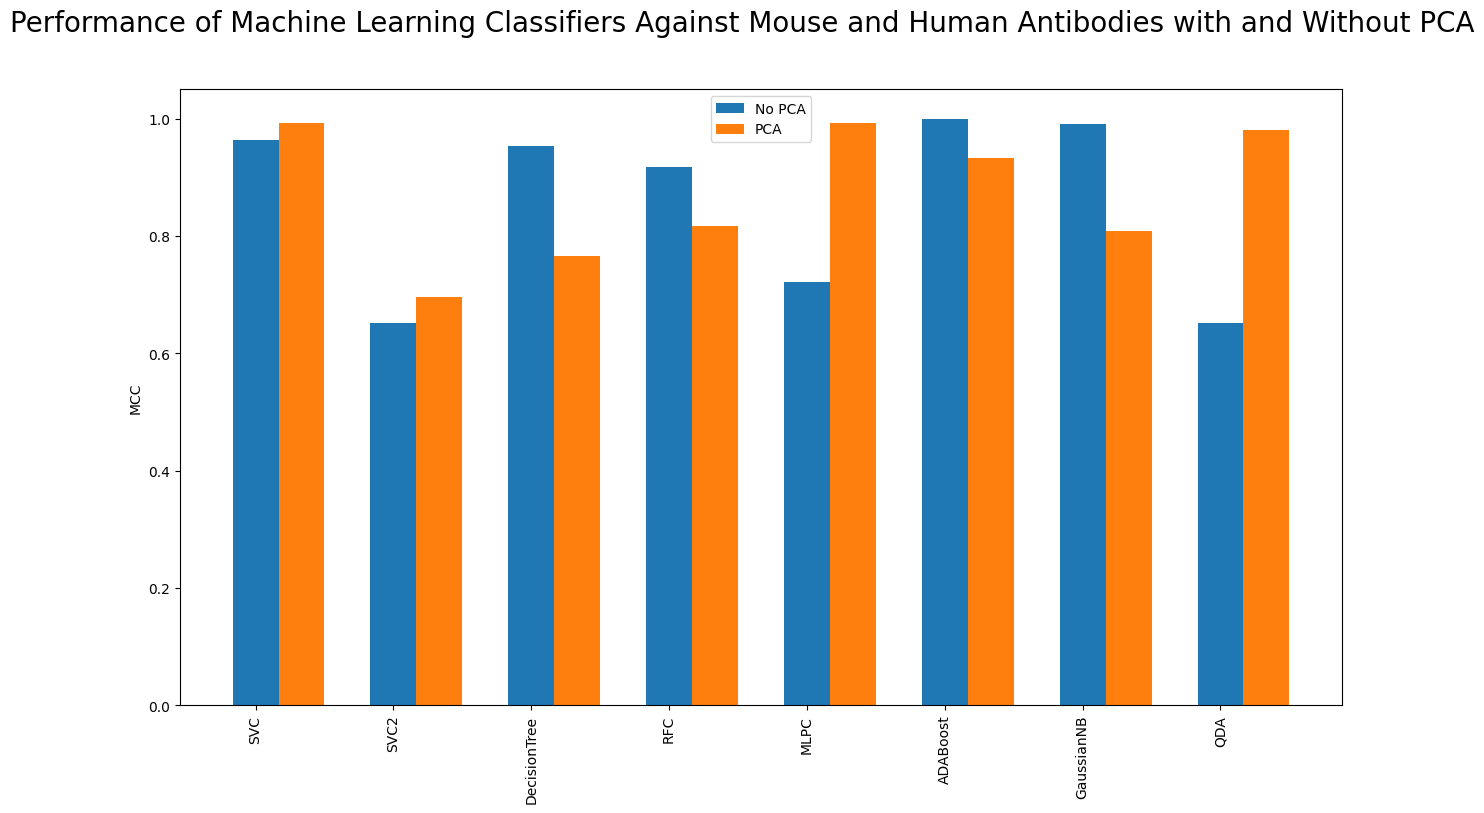

In [47]:
##Plot Score of Each Classifier Comparing Dataset with PCA and without PCA##
import numpy as np 
import matplotlib.pyplot as plt 
labels = list(classifiers.keys())
aranged = np.arange(len(classifiers)) 
width = 1/3
print(len(aranged),len(scores),len(scores_PCA))
fig, ax = plt.subplots(figsize=(15,8))

bar1 = plt.bar(aranged, scores, width,label = 'No PCA')
bar2 = plt.bar(aranged+width, scores_PCA , width,label = 'PCA')
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies with and Without PCA', fontsize=20)
ax.set_ylabel('MCC')
ax.set_xticks(aranged, labels, rotation = 90)
ax.legend()


plt.legend()
plt.show()

We see that some classifiers improve performance (SVC, MLPC,QDA) with the PCA but this is not always the case (Decision Tree, RFC, ADABoost). 

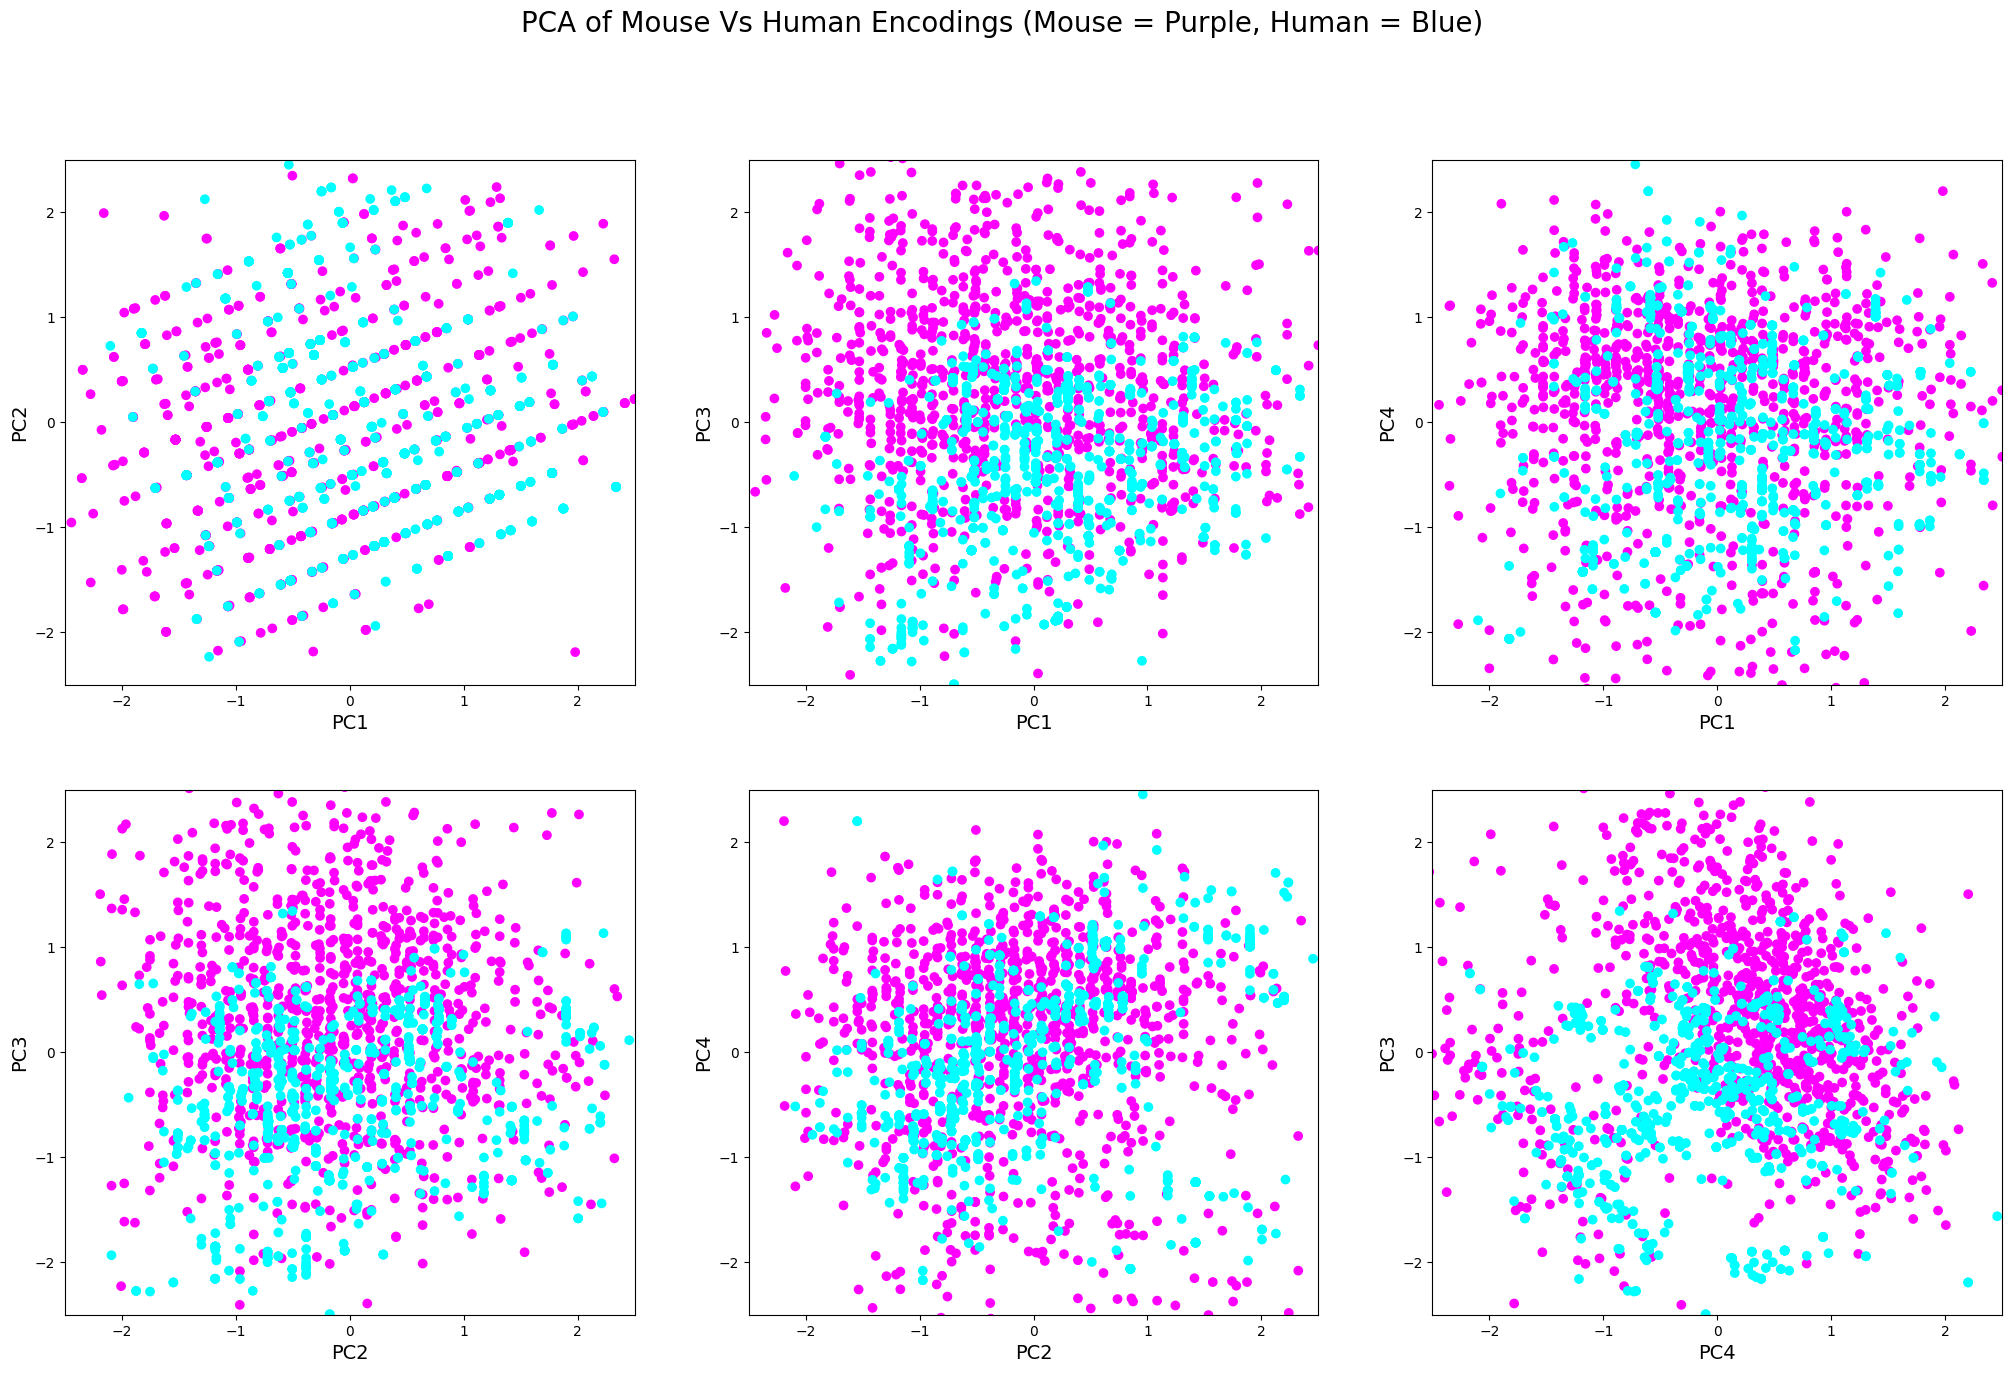

In [48]:
##Visualising Data Plot##
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(25, 15))
plt.suptitle('PCA of Mouse Vs Human Encodings (Mouse = Purple, Human = Blue)', fontsize=20)

ax[0, 0].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,1], c=y, cmap='cool');
ax[0, 0].set_xlabel('PC1', fontsize=14); ax[0, 0].set_xlim([-2.5,2.5]);
ax[0, 0].set_ylabel('PC2', fontsize=14); ax[0, 0].set_ylim([-2.5,2.5]);


ax[0, 1].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[0, 1].set_xlabel('PC1', fontsize=14); ax[0, 1].set_xlim([-2.5,2.5]);
ax[0, 1].set_ylabel('PC3', fontsize=14); ax[0, 1].set_ylim([-2.5,2.5]);


ax[0, 2].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,3], c=y, cmap='cool');
ax[0, 2].set_xlabel('PC1', fontsize=14); ax[0, 2].set_xlim([-2.5,2.5]);
ax[0, 2].set_ylabel('PC4', fontsize=14); ax[0, 2].set_ylim([-2.5,2.5]);


ax[1, 0].scatter(NewEncodingPCA[:,1], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[1, 0].set_xlabel('PC2', fontsize=14); ax[1, 0].set_xlim([-2.5,2.5]);
ax[1, 0].set_ylabel('PC3', fontsize=14); ax[1, 0].set_ylim([-2.5,2.5]);


ax[1, 1].scatter(NewEncodingPCA[:,1], NewEncodingPCA[:,3], c=y, cmap='cool');
ax[1, 1].set_xlabel('PC2', fontsize=14); ax[1, 1].set_xlim([-2.5,2.5]);
ax[1, 1].set_ylabel('PC4', fontsize=14); ax[1, 1].set_ylim([-2.5,2.5]);


ax[1, 2].scatter(NewEncodingPCA[:,3], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[1, 2].set_xlabel('PC4', fontsize=14); ax[1, 2].set_xlim([-2.5,2.5]);
ax[1, 2].set_ylabel('PC3', fontsize=14); ax[1, 2].set_ylim([-2.5,2.5]);




We can see here that the graphs showing PC1 against PC3 and PC2 against PC3 show some the best separation between human and mouse antibodies. We can use this to support the trustworthiness of our dimensionality reduction technique.

## Do it yourself

We can use other methods of reducing the dimensionality of the dataset. F-regression is a technique that selects the n most relevant features to the target variable. It can be performed on the dataset like so:

~~~
from sklearn.feature_selection import SelectKBest`
from sklearn.feature_selection import f_regression
n = 100
X_NUMPY, Y_NUMPY = X.to_numpy(),y.to_numpy()
fs = SelectKBest(score_func=f_regression, k=n)
X_selected = fs.fit_transform(X_NUMPY, Y_NUMPY)
~~~

- Experiment with the n this method of dimensionality reduction on your data and see how the results compare to the Principle Component Analysis

## Using Deep Learning to Classify Human and Mouse Antibodies

Using deep learning to construct our own artificial neural network using Keras, we can implement a different tehcnique to the machine learning we have demonstrated, above. These networks are sophisticated algorithms built by the computer, and trained to best perform on the data in question. 

Outlined below, is a very simple model with three layers, compiled to act as a binary classifier for our dataset. We set this model to run over 20 epochs, which is a very short training run. By giving the model more epochs to train, it is possible to obrain better results; however there comes a point where the model will overfit to your data, and demonstrate poor prediction ability with any new data that is presented to it.

In [49]:
##Import Deep Learning Modules##
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
import tensorflow as tf
from keras.callbacks import EarlyStopping


In [ ]:
#Initialising ANN##

X_train_np = np.asarray(X_train)
y_train_np = np.asarray(y_train)
X_test_np =  np.asarray(X_test)
y_test_np =  np.asarray(y_test)
print(X_train.shape)

ann = tf.keras.models.Sequential([tf.keras.layers.Dense(32, input_shape=(X_train.shape[1],)),
                                (tf.keras.layers.Dense(20,activation="relu")),
                                (tf.keras.layers.Dense(1,activation="sigmoid"))])

ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=[tf.keras.metrics.BinaryAccuracy()])
#Fitting ANN
es = EarlyStopping(monitor='val_loss', mode='min', patience=200)
history = ann.fit(X_train_np,y_train_np,epochs = 2000, validation_data =(X_test_np,y_test_np), verbose = 0,callbacks=[es])
performance = ann.evaluate(X_test_np, y_test_np)


(1400, 890)


In [ ]:
##Get Final Score Prediction##
predict = ann.predict(X_test_np)
predict_binary = []
for x in predict:
    if x[0] > 0.5:
        predict_binary.append(1)
    elif x[0] < 0.5:
        predict_binary.append(0)
performance = ann.evaluate(X_test_np, y_test_np)
#print(performance)
MCC = matthews_corrcoef(y_test,predict_binary)
print(MCC)

In [ ]:
##Plot Loss Function over Epochs##
history_dict = history.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

We plot the loss function of the deep learning algorithm over the epochs we set it to. This measures how well the algorithm learns our datasets, and the patterns behind it. It is expected that the loss would decrease over time for both the training and validation data. In some scenarios, however, the loss function may increase over time; but this is usually indicative of model overfitting.

## End of Chapter Exercise

We have seen that it is possible to separate mouse and human antibody protein sequences through their numerical encodings. But what if we wanted to separate antibody sequences from more species? Included in this worksheet is a dataset of 1000 rat antibodies, as well as the previously used 1000-entry human and mouse datasets. On your own, try to generate additional classifieres to separate increasing combinations of species (*i.e.* human versus rat, and mouse versus rat). Use any of the hyperparameterisation techniques that we have learned, as you see fit. 

- Report which of these classifiers was the easiest to build.

- Give reasons why some of these classifiers may be difficult to build.

## Keypoints

- Protein sequences must be numerically encoded to be readable by machine learning algorithms.

- It is sometimes necessary to experiment with different machine learning classifiers or hyperparameterisation techniques, to achieve the best prediction results.

- Check the performance of your model with a "held back" dataset which was not included in the training set.

 